# <div align="center">Q-Agent on IGT      

# Game plan
1. add punishment (negative rewards) possibility rather then have choices have either 1 positive posibility or 0
 - new variable 'pvalues' in objects: MultiArmedBandit, Qagent



2. add a 2nd alpha for punishment (negative rewards)
 - changes need to be made in: MultiArmedBandit object, Qagent object
 - include conditional that checks for + or - negative "rewards" and changes alpha before computing (r is (+)rewards, p is (-)rewards):
 				Q(s,a) += alpha_r * (r + max,Q(s') - Q(s,a)) 
 				Q(s,a) += alpha_p * (p + max,Q(s') - Q(s,a)) 


3. use the actual decks of cards used for the IGT instead of randomized values for the decks
 - deck will come from a csv type file


4. explore the 3D of the parameter space - alpha, beta pairs and payoff
 - different alpha ratios
 - different alpha amplitudes
 - different beta amplitudes
 
 
5. create a 2D heat map for assymetry of learning and explore/exploit values
 - pick out agents that are greedy, moderate, etc, etc

 
 
---

## IGT game design 
100 Trials total (from Bechara, 1997)

Deck A
- p(r) = 0.5
- p(p) = 0.5
- reward: \$100
- punishment (avg): -\$250
- overall gains: -\$75

Deck B
- p(r) = 0.9
- p(p) = 0.1
- reward: \$100
- punishment (avg): -\$1250
- overall gains: -\$75

Deck C
- p(r) = 0.5
- p(p) = 0.5
- reward: \$50
- punishment (avg): -\$50
- overall gains: \$0

Deck D
- p(r) = 0.9
- p(p) = 0.1
- reward: \$50
- punishment (avg): -\$250
- overall gains: \$20

#### Alternative designs
- switch overall gains of C & D so that C has positive gains and keeps p(r)=0.5, 
	and D has $0 gains and keeps p(r)=0.9
	- may be interesting to see the effect of alpha on frequency of rewards

In [164]:
from __future__ import division
import numpy as np
from numpy import array
from numpy.random import sample as rs
from numpy import newaxis as na
import pandas as pd
from scipy.stats import sem
import seaborn as sns
import string
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import csv
from __future__ import division
from future.utils import listvalues
from scipy.stats.stats import sem


In [41]:
def update_Qi(Qval, reward, alpha):
    """ update q-value of selected action, given reward and alpha
    """
    return Qval + alpha * (reward - Qval)


def update_Pall(Qvector, beta):
    """ update vector of action selection probabilities given
    associated q-values
    """ 
    Zvector = Qvector - max(Qvector)
    denom = np.sum(np.exp(beta * Zvector))
        
    resulting_pdata = np.array([np.exp(beta*Q_i) / denom for Q_i in Zvector])
    
    return resulting_pdata

In [43]:
class IowaGamblingTask(object):
    """ defines a multi-armed bandit task

    ::Arguments::
        preward (list): 1xN vector of reward probabilities for each of N bandits
        rvalues (list): 1xN vector of payout values for each of N bandits
    """    
            
    def __init__(self):
                
        self.all_cards = pd.read_csv('IGTCards.csv')
        self.deck_gains = self.all_cards.sum()
        self.deck_counters = np.zeros(len(self.all_cards.columns), dtype = int)
        


    def get_feedback(self, action_ix):
        
        
        if self.deck_counters[action_ix] == 49:
            self.deck_counters[action_ix] = 0
        
        else:    
            self.deck_counters[action_ix] += 1
        
        curr_counter = self.deck_counters[action_ix]
        
        feedback = self.all_cards.iloc[curr_counter, action_ix]
        
        return feedback

In [44]:
class Qagent(object):

    """ defines the learning parameters of single q-learning agent
    in a multi-armed bandit task

    ::Arguments::
        alpha_r (float): learning rate for rewards
        alpha_p (float): learning rate for punishments
        beta (float): inverse temperature parameter
        preward (list): 1xN vector of reward probaiblities for each of N decks
        rvalues (list): 1xN vector of payout values for each of N decks
                        IF rvalues is None, all values set to 1
        pvalues (list): 1xN vector of punishment values for each of N decks
                        IF rvalues is None, all values set to 1

    """

    def __init__(self, alpha_r=.04,
                       alpha_p=.02, 
                       beta=3.5, 
                       epsilon=.1, 
                       decks=['A', 'B', 'C', 'D']):

        if decks is None:
            decks = ['A', 'B', 'C', 'D']

        # calling IowaGamblingTask() function with arguments in Qagent() object
        self.IGT = IowaGamblingTask()
        
        #initializing alpha(r) function to set which alpha to use depending on +-r
        self.alpha = lambda r: alpha_r if r > 0 else alpha_p
        
        # setting parameters passed through Qagent() as arguments
        self.set_params(alpha_r=alpha_r, alpha_p=alpha_p, beta=beta, epsilon=epsilon, decks=decks)


    def set_params(self, **kwargs):
        
        """ update parameters of q-learning agent:
                alpha_r = learning rate for rewards
                alpha_p = learning rate for punishments
                beta = inv. temperature,
                epsilon = exploration constant to randomize decisions
                preward = probability of reward, p(reward)
                rvalues = reward amounts  (+$)
                pvalues = punishment amounts (-$)
        """

        kw_keys = list(kwargs)

        if 'alpha_r' in kw_keys:
            self.alpha_r = kwargs['alpha_r']

        if 'alpha_p' in kw_keys:
            self.alpha_p = kwargs['alpha_p']

        if 'beta' in kw_keys:
            self.beta = kwargs['beta']

        if 'epsilon' in kw_keys:
            self.epsilon = kwargs['epsilon']
        
        if 'decks' in kw_keys:
            self.decks = kwargs['decks']

        # number of choices/options
        self.nact = len(self.decks)

        # actions limited to number of choices/options
        self.actions = np.arange(self.nact)


    def play_IGT(self, ntrials=100, get_output=True):
        
        """ simulates agent performance on a multi-armed bandit task

        ::Arguments::
            ntrials (int): number of trials to play bandits
            get_output (bool): returns output DF if True (default)

        ::Returns::
            DataFrame (Ntrials x Nbandits) with trialwise Q and P
            values for each bandit
        """
        
        pdata = np.zeros((ntrials + 1, self.nact))
        
        pdata[0, :] = np.array([1/self.nact]*self.nact)
        
        qdata = np.zeros_like(pdata)
        self.choices = []
        self.feedback = []

        for t in range(ntrials):

            # select bandit arm (action)            
            act_i = np.random.choice(self.actions, p=pdata[t, :])
            
            # observe feedback
            r = self.IGT.get_feedback(act_i)

            # update value of selected action depending on whether it is a reward or punishment
            qdata[t+1, act_i] = update_Qi(qdata[t, act_i], r, self.alpha(r))

            # broadcast old q-values for unchosen actions
            for act_j in self.actions[np.where(self.actions!=act_i)]:
                qdata[t+1, act_j] = qdata[t, act_j]

            # update action selection probabilities and store data
            pdata[t+1, :] = update_Pall(qdata[t+1, :], self.beta)
            
            self.choices.append(act_i)
            self.feedback.append(r)

        
        self.pdata = pdata[1:, :]
        self.qdata = qdata[1:, :]
        self.make_output_df()

        if get_output:
            return self.data.copy()


    def make_output_df(self):
        """ generate output dataframe with trialwise Q and P measures for each bandit,
        as well as choice selection, and feedback
        """
        df = pd.concat([pd.DataFrame(dat) for dat in [self.qdata, self.pdata]], axis=1)
        columns = np.hstack(([['{}{}'.format(x, c) for c in self.actions] for x in ['q', 'p']]))
        df.columns = columns
        df.insert(0, 'trial', np.arange(1, df.shape[0]+1))
        df['choice'] = self.choices
        df['feedback'] = self.feedback
        
        # replace 3 with self.IGT.deck_gains.values.argmax()
        df['optimal'] = np.where(df['choice']==3, 1, 0)
        df.insert(0, 'agent', 1)
        self.data = df.copy()


    def simulate_multiple(self, nsims=10, ntrials=1000):
        """ simulates multiple identical agents on multi-armed bandit task
        """
        dflist = []
        for i in range(nsims):
            data_i = self.play_bandits(ntrials=ntrials, get_output=True)
            data_i['agent'] += i
            dflist.append(data_i)
        return pd.concat(dflist)

In [45]:
def get_optimal_auc(df, nblocks=25, verbose=False, as_percent=True):
    xdf = blockify_trials(df, nblocks=nblocks)
    muOptDF = xdf.groupby(['agent', 'block']).mean().reset_index()
    auc = pd.pivot_table(muOptDF, values='optimal', index='block').values.sum()
    if as_percent:
        auc = (auc / nblocks) * 100
        print("Optimal Choice chosen {:.2f}% of time".format(auc))
    if verbose:
        print("Optimal Choice chosen {:.2f} times".format(auc))

    return auc

def analyze_bandits(df, nblocks=25, get_err=False):
    xdf = blockify_trials(df, nblocks=nblocks)
    optDF = xdf.groupby(['agent', 'block']).mean().reset_index()
    muOpt = pd.pivot_table(optDF, values='optimal', index='block').values
    muOpt = np.hstack(muOpt)
    if get_err:
        errOpt = pd.pivot_table(optDF, values='optimal', index='block', aggfunc=sem).values*1.96
        errOpt = np.hstack(errOpt)
    else:
        errOpt = np.zeros_like(muOpt)
    return muOpt, errOpt

def blockify_trials(data, nblocks=5, conds=None, groups=['agent']):

    datadf = data.copy()
    if conds is not None:
        if type(conds) is str:
            conds = [conds]
        groups = groups + conds

    idxdflist = []
    for dfinfo, idxdf in datadf.groupby(groups):
        ixblocks = np.array_split(idxdf.trial.values, nblocks)
        blocks = np.hstack([[i+1]*arr.size for i, arr in enumerate(ixblocks)])
        idxdf = idxdf.copy()
        colname = 'block'
        idxdf[colname] = blocks
        idxdflist.append(idxdf)

    return pd.concat(idxdflist)


In [46]:
def plot_qlearning(data, nblocks=25, analyze=True):

    if analyze:
        auc = get_optimal_auc(data, nblocks, as_percent=True)

    sns.set(style='white', font_scale=1.3)
    clrs = ['#3778bf', '#feb308', '#9b59b6', '#2ecc71', '#e74c3c',
            '#3498db', '#fd7f23', '#694098', '#319455', '#f266db',
            '#13579d', '#fa8d67'  '#a38ff1'  '#3caca4', '#c24f54']

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3.5))
    df = data.copy()
    nactions = int(df.columns[-4].split('p')[-1])+1
    actions = np.arange(nactions)

    mudf = df.groupby('trial').mean().reset_index()
    errdf = df.groupby('trial').sem().reset_index()*1.96
    x = mudf.trial.values

    plot_err = True
    if np.isnan(errdf.loc[1, 'q0']):
        plot_err = False

    x3 = np.arange(1, nblocks+1)
    chance = 1/nactions
    mu3, err3 = analyze_bandits(df, nblocks=nblocks, get_err=plot_err)
    ax3.plot(x3, mu3, color='k')
    ax3.hlines(chance, 1, x3[-1], color='k', linestyles='--', label='chance')

    for i, act in enumerate(actions):
        muQ = mudf['q{}'.format(act)].values
        muP = mudf['p{}'.format(act)].values
        ax1.plot(x, muQ, label='$arm_{}$'.format(i), color=clrs[i])
        ax2.plot(x, muP, color=clrs[i])

        if plot_err:
            errQ = errdf['q{}'.format(act)].values
            errP = errdf['p{}'.format(act)].values
            ax1.fill_between(x, muQ-errQ, muQ+errQ, color=clrs[i], alpha=.2)
            ax2.fill_between(x, muP-errP, muP+errP, color=clrs[i], alpha=.2)
            if i==0:
                ax3.fill_between(x3, mu3-err3, mu3+err3, color='k', alpha=.15)
        else:
            ychance = np.ones(mu3.size) * chance
            mu3A = np.copy(mu3)
            mu3B = np.copy(mu3)
            mu3A[np.where(mu3<=chance)] = chance
            mu3B[np.where(mu3>=chance)] = chance
            ax3.fill_between(x3, ychance, mu3A, color='#2ecc71', alpha=.15)
            ax3.fill_between(x3, ychance, mu3B, color='#e74c3c', alpha=.15)

    ax1.legend(loc=4)
    ax1.set_ylabel('$Q(arm)$')
    ax1.set_title('Value')

    ax2.set_ylabel('$P(arm)$')
    ax2.set_ylim(0,1)
    ax2.set_title('Softmax Prob.')

    ax3.set_ylim(0,1)
    ax3.set_ylabel('% Optimal Deck')
    ax3.set_xticks([1, nblocks+1])
    ax3.set_xticklabels([1, df.trial.max()])
    ax3.legend(loc=4)

    for ax in f.axes:
        ax.set_xlabel('Trials')
    plt.tight_layout()
    sns.despine()


In [47]:
def get_IGT_scores(data):
    
    # initializing a choice dictionary with the default of 0 times chosen
    choice_dict = {0: 0, 1:0, 2:0, 3:0}
    
    # updating the choice dictionary with the deck choices made
    choices_made = data['choice'].value_counts(sort = False).to_dict()
    
    for key, value in choices_made.items():
        choice_dict[key] = value

    A, B, C, D = choice_dict.get(0), choice_dict.get(1), choice_dict.get(2), choice_dict.get(3)
    
    # Payoff (P)
    payoff = (C + D) - (A + B)
    
    # Sensitivity to frequency of gains (Q)
    sensitivity = (B + D) - (A + C)
    
    return pd.Series((payoff, sensitivity))

In [497]:
def plot_scatter(data):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # here are the x,y and respective z values
    x = data["Alpha R"].values.astype('float')
    y = data["Alpha P"].values.astype('float')
    z = data["Beta"].values.astype('float')

    # this is the value to use for the color
    c = data["Payoff"].values.astype('float')

    img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
    fig.colorbar(img)
    plt.show()

In [496]:
def plot_heatmaps(data):
    
    # here are the x,y and respective z values
    X = data["Alpha R"].values.astype('float')
    Y = data["Alpha P"].values.astype('float')
    Z = data["Beta"].values.astype('float')

    # this is the value to use for the color
    V = data["Payoff"].values.astype('float')
    
    X, Y = np.meshgrid(X, Y)
    
    Z, V = np.meshgrid(Z, V)
    
    # create the figure, add a 3d axis, set the viewing angle
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    
    # fourth dimention - colormap
    # create colormap according to x-value (can use any 50x50 array)
#     color_dimension = V # change to desired fourth dimension
#     minn, maxx = color_dimension.min(), color_dimension.max()
#     norm = matplotlib.colors.Normalize(minn, maxx)
#     m = plt.cm.ScalarMappable(norm=norm, cmap='jet')
#     m.set_array([])
#     fcolors = m.to_rgba(color_dimension)
    
    #scamap = plt.cm.ScalarMappable(cmap='inferno')
    #fcolors = scamap.to_rgba(V)
    
    # here we create the surface plot, but pass V through a colormap
    # to create a different color for each patch
    surf = ax.plot_surface(X, Y, Z, facecolors = cm.Oranges(V), linewidth = 0, antialiased = False)
    ax.set_zlim(0, 1)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    
    fig.colorbar(surf)
    
    plt.show()

# ---------
#     x = data["Alpha R"].values.astype('float')
#     y = data["Alpha P"].values.astype('float')
#     z = data["Beta"].values.astype('float')
#     v = data["Payoff"].values.astype('float')

#     fig = plt.figure()
#     ax = fig.gca(projection='3d')

#     ax.plot_trisurf(x, y, z, facecolor=cm.Oranges(V), linewidth=0.2, antialiased=True)

#     plt.show()

In [502]:
def agent_df():
    df_columns = np.array(['Alpha R', 'Alpha P', 'Beta', 'Payoff', 'Sensitivity'])
    df = pd.DataFrame(columns=df_columns)
    
    for alpha_r in np.arange(-1, 1, .2):
        for alpha_p in np.arange(-1, 1, .2):
            for beta in np.arange(0, 1, .2):
                
                alpha_r, alpha_p, beta = np.round(alpha_r, 1), np.round(alpha_p, 1), np.round(beta, 1)
                agent = Qagent(alpha_r=alpha_r, alpha_p=alpha_p, beta=beta)
                data = agent.play_IGT(ntrials=100, get_output=True)
                scores = get_IGT_scores(data)
                payoff, sensitivity = scores.iloc[0], scores.iloc[1]
                trial_df = pd.DataFrame([[alpha_r, alpha_p, beta, payoff, sensitivity]], columns = df_columns)
                df = df.append(trial_df)
                df.reset_index(drop=True, inplace=True)

    
    return df
        
def find_optimal_agent():
    df = agent_df()
    plot_scatter(df)
    plot_heatmaps(df)

In [499]:
data = agent_df()

In [500]:
data.sort_values(by = 'Payoff', ascending=False)
#data["Alpha R"]

,Alpha R,Alpha P,Beta,Payoff,Sensitivity
401,0.6,-1.0,0.2,100,-100
411,0.6,-0.6,0.2,100,100
407,0.6,-0.8,0.4,100,-100
404,0.6,-1.0,0.8,100,-100
403,0.6,-1.0,0.6,100,-100
456,0.8,-0.8,0.2,100,-100
451,0.8,-1.0,0.2,100,-100
452,0.8,-1.0,0.4,100,-100
361,0.4,-0.6,0.2,100,-100
362,0.4,-0.6,0.4,100,-100


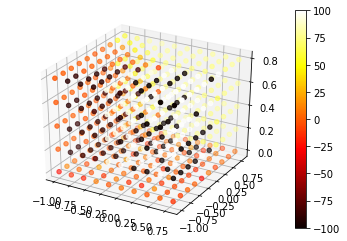

TypeError: You must first set_array for mappable

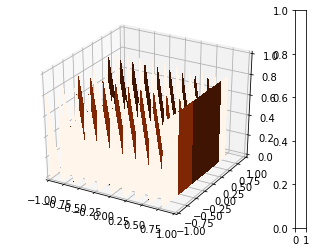

In [503]:
find_optimal_agent()

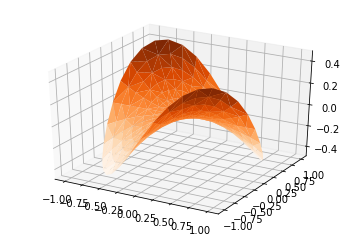

In [293]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


n_radii = 8
n_angles = 36

# Make radii and angles spaces (radius r=0 omitted to eliminate duplication).
radii = np.linspace(0.125, 1.0, n_radii)
angles = np.linspace(0, 2*np.pi, n_angles, endpoint=False)

# Repeat all angles for each radius.
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)

# Convert polar (radii, angles) coords to cartesian (x, y) coords.
# (0, 0) is manually added at this stage,  so there will be no duplicate
# points in the (x, y) plane.
x = np.append(0, (radii*np.cos(angles)).flatten())
y = np.append(0, (radii*np.sin(angles)).flatten())

# Compute z to make the pringle surface.
z = np.sin(-x*y)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True, cmap=cm.Oranges)

plt.show()


In [ ]:
# datax.head()

#  trial: trial number
#  q0: Q-value (i.e., expected value) of first bandit
#  p0: soft-max probability of selecting first bandit
#  choice: chosen bandit
#  feedback: feedback value returned by chosen bandit
#  optimal: did the agent choose the optimal action (1) or not (0)

In [ ]:
agent = Qagent(alpha_r=.2,
        alpha_p=.0, 
        beta=0.2, 
        epsilon=.1)

# play 800 trials of multi-armed bandit task
data0 = agent.play_IGT(ntrials=100, get_output=True)

data0.head()

# plot Q-values and softmax selection prob. for each bandit
plot_qlearning(data0)

In [ ]:
get_IGT_scores(data0)

In [ ]:
agent = Qagent(alpha_r=.04,
        alpha_p=-.02, 
        beta=.01, 
        epsilon=.1, 
        decks=['A','B','C','D'])

# play 800 trials of multi-armed bandit task
data1 = agent.play_IGT(ntrials=100, get_output=True)

data1.head()

# plot Q-values and softmax selection prob. for each bandit
plot_qlearning(data1)

In [ ]:
agent = Qagent(alpha_r=.4,
        alpha_p=.2, 
        beta=.01, 
        epsilon=.1, 
        decks=['A','B','C','D'])

# play 800 trials of multi-armed bandit task
data2 = agent.play_IGT(ntrials=100, get_output=True)

data2.head()

# plot Q-values and softmax selection prob. for each bandit
plot_qlearning(data2)

In [ ]:
agent = Qagent(alpha_r=.8,
        alpha_p=.4, 
        beta=3.5, 
        epsilon=.1, 
        decks=['A','B','C','D'])

# play 800 trials of multi-armed bandit task
data3 = agent.play_IGT(ntrials=100, get_output=True)

#  trial: trial number
#  q0: Q-value (i.e., expected value) of first bandit
#  p0: soft-max probability of selecting first bandit
#  choice: chosen bandit
#  feedback: feedback value returned by chosen bandit
#  optimal: did the agent choose the optimal action (1) or not (0)
data3.head()

# plot Q-values and softmax selection prob. for each bandit
plot_qlearning(data3)

In [ ]:
agent = Qagent(alpha_r=.01,
        alpha_p=.02, 
        beta=3.5, 
        epsilon=.1, 
        decks=['A','B','C','D'])

# play 800 trials of multi-armed bandit task
data4 = agent.play_bandits(ntrials=100, get_output=True)

#  trial: trial number
#  q0: Q-value (i.e., expected value) of first bandit
#  p0: soft-max probability of selecting first bandit
#  choice: chosen bandit
#  feedback: feedback value returned by chosen bandit
#  optimal: did the agent choose the optimal action (1) or not (0)
data4.head()

# plot Q-values and softmax selection prob. for each bandit
plot_qlearning(data4)

In [ ]:
agent = Qagent(alpha_r=.02,
        alpha_p=-.02, 
        beta=3.5, 
        epsilon=.1, 
        decks=['A','B','C','D'])

# play 100 trials of multi-armed bandit task
data5 = agent.play_bandits(ntrials=100, get_output=True)

data5.head()

# plot Q-values and softmax selection prob. for each bandit
plot_qlearning(data5)

magnitude of learning
greediness of decision policy
assymetry of decision policy

(looka t this whole space)

3d map --> sample, alpha, ratio, amplitudes, amplitudes of beta, giant map of payoff scores, sensitivty for configurations

find baseline parameters, lowest beta, lowest alpha, symmetrical learning rates

new repo, and porting this moves over the code, runs this notebook first, 

pulling from actual decks

2D heat map for assymetry of learning and ... greedy, moderate agents etc, and how they very along those dimensions
